[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ee-ortiz/ISIS-4825_202510_IMAGENES_Y_VISION/blob/main/Laboratorio_07/Taller/MISIS4825_Laboratorio07_Taller.ipynb)

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# Laboratorio 07 - Taller: Redes Neuronales Convolucionales

En este taller profundizaremos en el diseño, implementación y optimización de redes neuronales convolucionales (CNNs) para tareas de clasificación de imágenes. Utilizaremos el conjunto de datos **Covid-19 Chest X-Ray Images**, el cual contiene imágenes de radiografías de tórax de personas diagnosticadas con COVID-19 y personas sin la enfermedad.

El objetivo principal es construir y optimizar modelos de CNN propios que permitan distinguir entre las diferentes clases presentes en el dataset.


## Instrucciones del Taller

### 1. Diseño y Construcción de una Red Convolucional Propia

- **Arquitectura de la CNN:**  
  Diseñe una arquitectura de CNN personalizada utilizando Keras. Explique las decisiones tomadas en cada etapa, tales como:
  - Número y tipo de capas convolucionales.
  - Tamaño de los filtros y kernels.
  - Elección de las capas de pooling (MaxPooling2D, AveragePooling2D, etc.).
  - Funciones de activación utilizadas (por ejemplo, ReLU).
  - Implementación de técnicas de regularización (por ejemplo, Dropout) para prevenir el sobreajuste.
- **Preprocesamiento de Datos:**  
  Realice el preprocesamiento adecuado de los datos, como reescalado (normalización) y data augmentation, y divida el conjunto de datos en entrenamiento, validación y test.
- **Documentación:**  
  Justifique las decisiones de diseño y preprocesamiento, explicando cómo cada elección impacta el rendimiento del modelo.

### 2. Experimentación y Optimización del Modelo

- **Ajuste de Arquitectura y Hiperparámetros:**  
  Realice experimentos modificando la arquitectura base de su CNN. Algunas ideas incluyen:
  - Variar el número de capas convolucionales y neuronas en las capas densas.
  - Ajustar los parámetros de las capas de pooling.
  - Modificar la tasa de Dropout, la tasa de aprendizaje, y el tamaño del batch.
- **Evaluación de Resultados:**  
  Documente y analice los resultados obtenidos en cada experimento. Utilice métricas como precisión, recall, F1-score y la matriz de confusión para evaluar el desempeño.
- **Visualización:**  
  Genere gráficos que muestren la evolución de la precisión y la pérdida durante el entrenamiento, así como las matrices de confusión para comparar las distintas configuraciones.

### 3. Análisis y Discusión de Resultados

- **Comparación de Experimentos:**  
  Compare el rendimiento de su modelo base con las variantes experimentales. Analice y discuta:
  - ¿Qué impacto tiene la profundidad de la red y el número de filtros en la capacidad de aprendizaje?
  - ¿Cómo influyen las técnicas de regularización (por ejemplo, Dropout) en la capacidad de generalización del modelo?
  - ¿Qué mejoras adicionales se podrían implementar para optimizar aún más el rendimiento del modelo?
- **Reflexión:**  
  Plantee conclusiones y proponga futuras líneas de trabajo o posibles ajustes en la arquitectura que podrían mejorar la clasificación.


**Datos:** [Covid-19 Chest X-Ray Images](https://www.kaggle.com/datasets/sachinkumar413/cxr-2-classes)

### **Integrantes**
- Nicolas Ruiz Perez - 202123608
- Valeria Caro Ramirez - 202111040

### **Descarga y Preparación del dataset**


In [ ]:
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install seaborn
%pip install scikit-learn
%pip install 'tensorflow[and-cuda]'
%pip install kaggle 

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from kaggle.api.kaggle_api_extended import KaggleApi

In [ ]:
api = KaggleApi()
api.authenticate()
api.dataset_download_files('sachinkumar413/cxr-2-classes', path='data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/sachinkumar413/cxr-2-classes


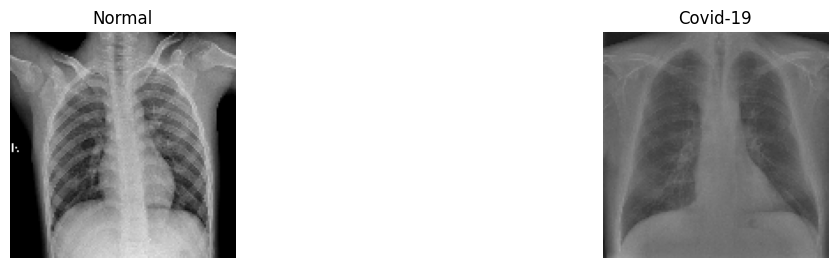

In [10]:
data_dir = 'data'
categories = os.listdir(data_dir)

plt.figure(figsize=(12, 10))
for i, category in enumerate(categories):
    folder = os.path.join(data_dir, category)
    image_file = os.listdir(folder)[0]
    img_path = os.path.join(folder, image_file)

    # Cargar imagen original
    img = keras.preprocessing.image.load_img(img_path, target_size=(128,128))
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0

    plt.subplot(4, 2, i+1)
    plt.imshow(img_array)
    plt.title(category)
    plt.axis('off')
plt.tight_layout()
plt.show()


### **Preparación de Datos y División en Entrenamiento, Validación y Test**

In [11]:
filepaths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir)
             for f in filenames if os.path.splitext(f)[1].lower() in ['.png','.jpg','.jpeg']]
labels = [os.path.split(os.path.split(path)[0])[1] for path in filepaths]

data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})

train_df, test_val_df = train_test_split(data_df, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=2/3, random_state=42)

print("Total de imágenes:", len(data_df))
print("Entrenamiento:", len(train_df))
print("Validación:", len(val_df))
print("Test:", len(test_df))

Total de imágenes: 1675
Entrenamiento: 1172
Validación: 336
Test: 167


#### **Procesamiento de Datos**  
   

In [13]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
)

test_val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
)

val_gen = test_val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    shuffle=False,
)

test_gen = test_val_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    shuffle=False,
)

Found 1172 validated image filenames belonging to 2 classes.
Found 336 validated image filenames belonging to 2 classes.


Found 167 validated image filenames belonging to 2 classes.


El preprocesamiento de datos implementado busca optimizar el entrenamiento de la CNN y garantizar su capacidad de generalización. La normalización de píxeles (rescale=1/255) estandariza los valores al rango [0,1], facilitando la convergencia durante el entrenamiento. Las transformaciones de aumento de datos en el generador de entrenamiento (rotación de 20° y flip horizontal) introducen variabilidad artificial en el dataset, simulando diferentes perspectivas y orientaciones de las imágenes. Esto mitiga el sobreajuste al exponer el modelo a mayor diversidad morfológica durante el aprendizaje, mejorando su robustez frente a variaciones en datos nuevos. Para los conjuntos de validación y prueba se omite el aumento de datos, ya que deben evaluar el rendimiento con información no modificada, replicando condiciones reales de inferencia. El redimensionamiento a 128x128 pixeles homogeniza la entrada de la red, mientras que el shuffle=False en validación/test asegura una evaluación consistente al preservar el orden original. El flujo desde dataframes permite una integración flexible con estructuras de almacenamiento externas, facilitando la gestión de datasets grandes mediante carga dinámica en lotes de 32 muestras. Estas estrategias combinadas optimizan el uso de recursos computacionales y preparan los datos para un entrenamiento estable y una evaluación confiable del modelo.

### **Construcción y Compilación del Modelo 1 de Red Convolucional**

In [ ]:
# Construcción del modelo CNN
model = Sequential([
    # Primera capa convolucional: extrae características básicas
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional: extrae características más complejas
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Aplanamiento para conectar con las capas densas
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(len(categories), activation='softmax')  # Capa de salida para clasificación
])

# Resumen del modelo para verificar la arquitectura
model.summary()

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

La arquitectura propuesta de la CNN está diseñada para equilibrar eficiencia computacional y capacidad de aprendizaje jerárquico en clasificación de imágenes. La primera capa actúa como extractor de características primarias (bordes, texturas) mediante filtros pequeños (3x3), ideal para capturar patrones locales sin sobrecarga paramétrica. El uso de ReLU introduce no-linealidad crítica para modelar relaciones complejas, evitando el problema de gradien vanishing. La subsiguiente reduce dimensionalidad espacial (128x128 a 64x64), disminuyendo costos computacionales y enfatizando características dominantes mediante invariancia traslacional. La segunda capa  profundiza la abstracción, aumentando filtros (16 a 32) para detectar patrones compuestos (formas, combinaciones de texturas), mientras el MaxPooling2D posterior (64x64 a 32x32) continúa optimizando la representación. El Flatten() transforma los mapas de características 2D en un vector 1D, permitiendo la transición a capas densas. La capa Dense(16) actúa como cuello de botella para comprimir información relevante antes de la clasificación, mientras el Dropout(0.2) reduce overfitting al desactivar aleatoriamente neuronas durante el entrenamiento, forzando redundancia en el aprendizaje. Finalmente, la capa Dense(len(categories)) con softmax genera probabilidades normalizadas para cada clase, adaptándose dinámicamente al número de categorías. Esta progresión sigue el principio de simplicidad-complejidad incremental: capas iniciales enfocadas en bajo nivel, capas posteriores en semántica global. La elección de 16-32 filtros evita sobreparametrización en imágenes de resolución moderada (128x128), siendo adecuada para datasets no extremadamente grandes. La ausencia de capas muy profundas previene vanishing gradients y facilita entrenamiento con recursos limitados, manteniendo expresividad suficiente para tareas de clasificación básicas a intermedias.

### **Definición de Callbacks**

In [16]:
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True,
                                   monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

callbacks = [model_checkpoint, early_stopping, reduce_lr]

Los callbacks implementados optimizan el entrenamiento de la CNN mediante un enfoque adaptativo que equilibra eficiencia y generalización. ModelCheckpoint guarda solo el mejor modelo según la pérdida de validación, asegurando la recuperación del estado óptimo del modelo. EarlyStopping detiene el entrenamiento si no hay mejora en val_loss después de 10 épocas, evitando sobreajuste. ReduceLROnPlateau ajusta dinámicamente la tasa de aprendizaje reduciéndola un 90% si la pérdida de validación se estanca durante 5 epochs, permitiendo un ajuste más fino cerca de mínimos locales.

### **Entrenamiento del Modelo**

In [17]:
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=callbacks
    )

/home/pukini/.pyenv/versions/3.12.9/envs/iv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.7137 - loss: 0.6635 - val_accuracy: 0.9613 - val_loss: 0.1212 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9731 - loss: 0.1082 - val_accuracy: 0.9673 - val_loss: 0.0925 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9666 - loss: 0.1078 - val_accuracy: 0.9613 - val_loss: 0.0957 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9728 - loss: 0.0846 - val_accuracy: 0.9702 - val_loss: 0.0860 - learning_rate: 0.0010
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9740 - loss: 0.0755 - val_accuracy: 0.9643 - val_loss: 0.1005 - learning_rate: 0.0010
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9828 - loss: 0.0522 - val_accuracy: 0.9673 - val_loss: 0.0886 - learning_rate: 0.0010
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9781 - loss: 0.0689 - val_ac

### **Evaluación del Modelo**

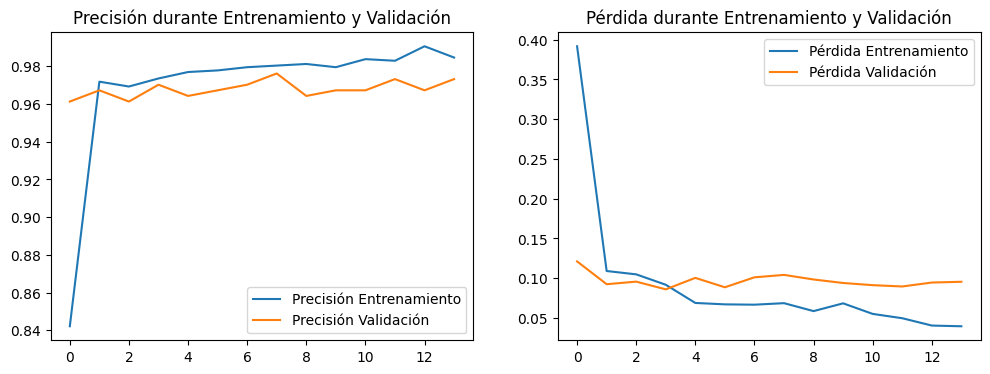

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


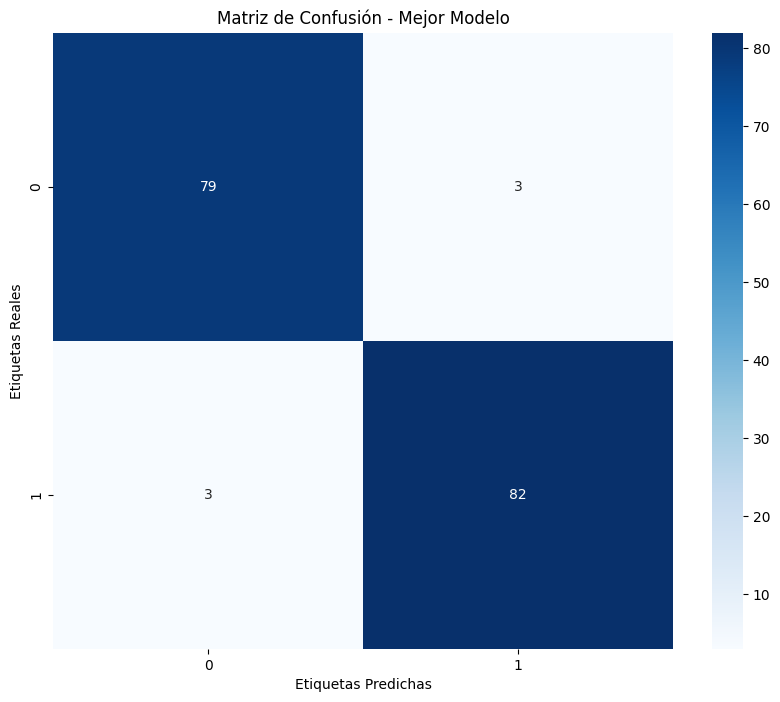

              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96        82
    Covid-19       0.96      0.96      0.96        85

    accuracy                           0.96       167
   macro avg       0.96      0.96      0.96       167
weighted avg       0.96      0.96      0.96       167



In [ ]:
# Visualización de la evolución del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión Validación')
plt.legend(loc='lower right')
plt.title('Precisión durante Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida Validación')
plt.legend(loc='upper right')
plt.title('Pérdida durante Entrenamiento y Validación')
plt.show()

# Cargar el modelo guardado con el mejor desempeño en validación
best_model = load_model('best_model.keras')

# Evaluar el modelo en el conjunto de test
test_gen.reset()
predicciones = best_model.predict(test_gen, verbose=1)
y_pred = np.argmax(predicciones, axis=1)
y_test = test_gen.classes

# Calcular y mostrar la matriz de confusión y el reporte de clasificación


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Mejor Modelo')
plt.ylabel('Etiquetas Reales')
plt.xlabel('Etiquetas Predichas')
plt.show()

print(classification_report(y_test, y_pred, target_names=categories, zero_division=0))



Como se observa, la precisión durante el entrenamiento muestra un aumento gradual, lo que es esperado en la mayoría de los modelos de aprendizaje automático. Este aumento se debe a que el modelo se ajusta progresivamente a los datos de entrenamiento. Sin embargo, esta precisión es consistentemente superior a la de la validación, lo que indica que el modelo está experimentando un ligero sobreajuste en los datos de entrenamiento. El sobreajuste ocurre cuando el modelo aprende demasiado bien las particularidades de los datos, lo que impide que pueda generalizar correctamente a nuevos datos. Esto explica la menor precisión en el conjunto de validación, ya que el modelo no logra abstraer los patrones de forma suficiente para realizar predicciones precisas en datos no vistos previamente.

Por otro lado, la pérdida durante el entrenamiento sigue una tendencia decreciente, lo cual es una señal positiva de que el modelo está aprendiendo a minimizar el error en los datos de entrenamiento. Sin embargo, la pérdida en el conjunto de validación se mantiene relativamente constante a lo largo de todo el proceso de entrenamiento. Esto sugiere que el modelo no mejora significativamente su capacidad para generalizar, ya que la validación no muestra una disminución correspondiente en el error. Esto también podría estar relacionado con el sobreajuste mencionado anteriormente.

En cuanto a las métricas obtenidas, se observa un valor de 0.96 en todas las métricas para todas las clases, lo que indica que el modelo tiene un rendimiento excepcional tanto en precisión como en consistencia. Esto sugiere que el modelo clasifica correctamente las muestras en ambas clases, sin mostrar sesgos hacia alguna de ellas. Además, la alta consistencia en todas las métricas refleja que el modelo no solo tiene un buen desempeño general, sino que también mantiene esa calidad en cada una de las clases, lo que es un indicativo de que no existe un desequilibrio significativo en la capacidad de clasificación del modelo entre las diferentes clases.